### Optional Alternative Models for Assessing Novelty

Applied to the demonstration set. 

In [23]:
import numpy as np

from sklearn.datasets import make_blobs
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import gaussian_kde

from mi_density import *

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

SAVE = True
FIGSIZE = (3.5, 3.5)
POS = [0.17, 0.17, 0.8, 0.8]


In [24]:
blob_params = [
    {"center": [0, 0], "std": 0.1, "random_state": 10},
    {"center": [1, 1], "std": 0.3, "random_state": 5},
    {"center": [2, 2], "std": 0.5, "random_state": 6},
    {"center": [2, 1], "std": 0.1, "random_state": 11},
]

# Generate all blobs and concatenate
X = np.vstack(
    [
        make_blobs(
            n_samples=20,
            centers=[params["center"]],
            cluster_std=params["std"],
            random_state=params["random_state"],
        )[0]
        for params in blob_params
    ]
)

X_dm = squareform(pdist(X, metric="euclidean"))

#### MI Method

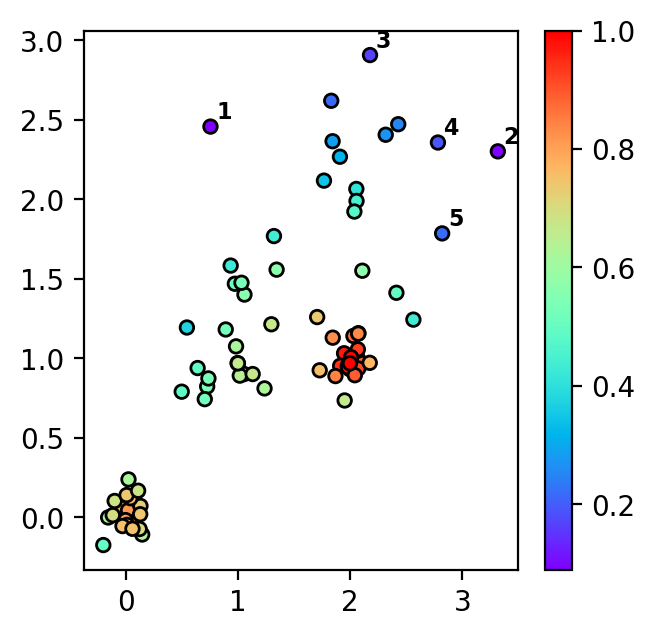

In [25]:
cutoff, mi_profile = get_MI_profile(X_dm, 200)
dens = compute_mi_density(X_dm, cutoff, mi_profile)
dens = dens / dens.max()  # normalize to [0, 1] for colorbar

fig, ax = plt.subplots(figsize=FIGSIZE, dpi=200)
ax.set_position(POS, which="both")
scatter = ax.scatter(X[:, 0], X[:, 1], c=dens, marker=".", s=95, cmap="rainbow", ec="k")

# add cbar
cbar = plt.colorbar(scatter, ax=ax)

for i, d in enumerate(np.argsort(dens)[:5]):
    plt.annotate(
        f"{i+1}", (X[d, 0] + 0.05, X[d, 1] + 0.05), color="k", fontsize=8, weight="bold"
    )


plt.show()

#### KDE Method

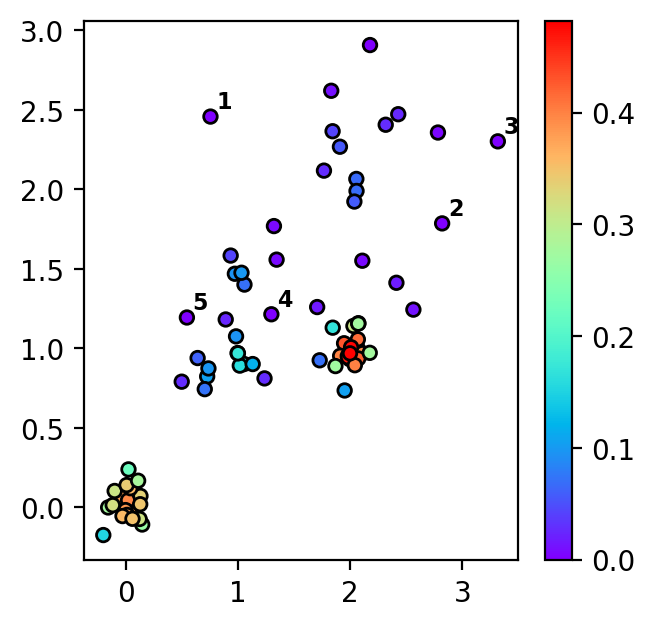

In [26]:
def compute_kde_density(distance_matrix):
    """
    Fit a gloabl bandwidth and compute KDE density for each row in a distance matrix.
    """
    all_dist = distance_matrix[np.triu_indices(len(distance_matrix), k=1)]
    kde_all = gaussian_kde(all_dist, bw_method='scott')
    global_bandwidth = kde_all.factor * np.std(all_dist, ddof=1)

    kde_dens = []
    for row in distance_matrix:
        kde = gaussian_kde(row[row > 0], bw_method=global_bandwidth)
        kde_dens.append(kde.evaluate(0)[0])

    return np.array(kde_dens)

kde_dens = compute_kde_density(X_dm)

fig, ax = plt.subplots(figsize=FIGSIZE, dpi=200)
ax.set_position(POS, which="both")
scatter = ax.scatter(X[:, 0], X[:, 1], c=kde_dens, marker=".", s=95, cmap="rainbow", ec="k")

# add cbar
cbar = plt.colorbar(scatter, ax=ax)

for i, d in enumerate(np.argsort(kde_dens)[:5]):
    plt.annotate(
        f"{i+1}", (X[d, 0] + 0.05, X[d, 1] + 0.05), color="k", fontsize=8, weight="bold"
    )

plt.show()

#### KNN Approach

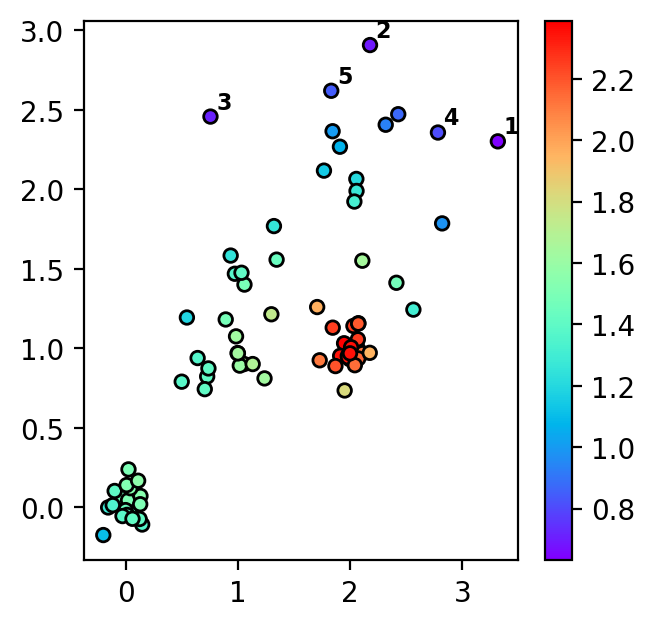

In [27]:
def compute_knn_density(distance_matrix, k=10):
    """
    Compute KNN density for each row of a distance matrix based on the average distance
    to its k-nearest neighbors.
    """
    knn_dens = []
    for row in distance_matrix:
        knn_distances = np.sort(row[row > 0])[:k]  # Get the k-nearest nonzero distances
        knn_density = 1.0 / (np.mean(knn_distances) + 1e-10)  # Avoid division by zero
        knn_dens.append(knn_density)
    
    return np.array(knn_dens)

# knn_dens = compute_knn_density(X_dm, k=int(np.sqrt(len(X_dm)))) # sqrt(N)
knn_dens = compute_knn_density(X_dm, k=int((4 / (3 * len(X_dm))) ** (1 / 5) * len(X_dm))) # silvermans rule

fig, ax = plt.subplots(figsize=FIGSIZE, dpi=200)
ax.set_position(POS, which="both")
scatter = ax.scatter(X[:, 0], X[:, 1], c=knn_dens, marker=".", s=95, cmap="rainbow", ec="k")

# add cbar
cbar = plt.colorbar(scatter, ax=ax)

for i, d in enumerate(np.argsort(knn_dens)[:5]):
    plt.annotate(
        f"{i+1}", (X[d, 0] + 0.05, X[d, 1] + 0.05), color="k", fontsize=8, weight="bold"
    )

plt.show()

### Local Outlier Factor 

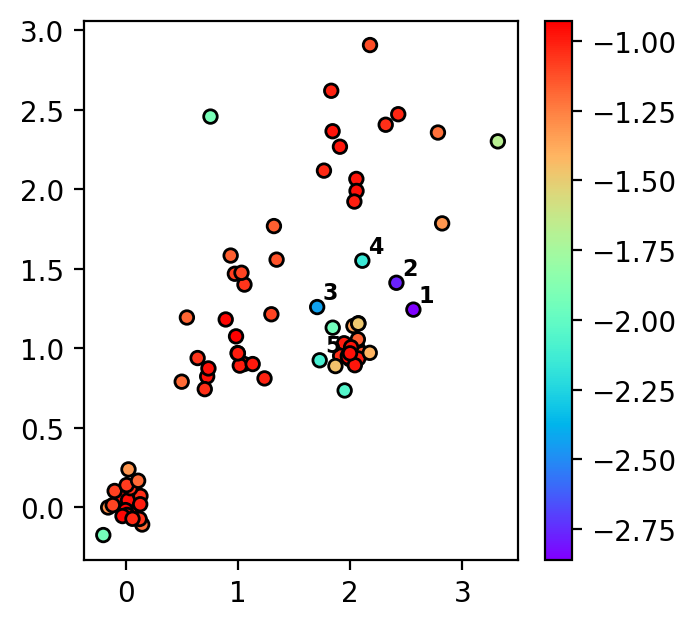

In [28]:
def compute_lof_density(distance_matrix, n_neighbors=20):
    """
    Compute LOF density for each row in a distance matrix.
    """

    lof = LocalOutlierFactor(n_neighbors=n_neighbors, metric="precomputed")
    lof.fit(distance_matrix)


    return lof.negative_outlier_factor_

# lof_dens = compute_lof_density(X_dm, n_neighbors=10) # sqrt(N)
lof_dens = compute_lof_density(X_dm, n_neighbors=int(np.sqrt(len(X_dm)))) # sqrt(N)
# lof_dens = compute_lof_density(X_dm, n_neighbors=int((4 / (3 * len(X_dm))) ** (1 / 5) * len(X_dm))) # silvermans rule


fig, ax = plt.subplots(figsize=FIGSIZE, dpi=200)
ax.set_position(POS, which="both")
scatter = ax.scatter(X[:, 0], X[:, 1], c=lof_dens, marker=".", s=95, cmap="rainbow", ec="k")

# add cbar
cbar = plt.colorbar(scatter, ax=ax)

for i, d in enumerate(np.argsort(lof_dens)[:5]):
    plt.annotate(
        f"{i+1}", (X[d, 0] + 0.05, X[d, 1] + 0.05), color="k", fontsize=8, weight="bold"
    )

plt.show()